## Preliminaries
This section contains the boilerplate necessary for the other sections. Run it first.

In [1]:
from models.detector import Detector
import torch
import torch.nn as nn
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from datasets.coco import build, CocoDetection
from pathlib import Path
import cv2
from PIL import Image
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader
from util.misc import nested_tensor_from_tensor_list
import skimage
import colorsys
import random
from skimage.measure import find_contours
from matplotlib.patches import Polygon
from skimage import io
import argparse
import datasets.transforms as T
import copy
import glob
import re
torch.set_grad_enabled(False);

In [2]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [3]:
def make_coco_transforms(image_set, args):

    normalize = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    scales = [800]

    if image_set == 'val' or image_set == 'train':
        return T.Compose([
            T.RandomResize([scales[-1]], max_size=scales[-1] * 1333 // 800),
            normalize,
        ])

    raise ValueError(f'unknown {image_set}')

def plot_gt(im, labels, bboxes_scaled, output_dir):
    tl = 3
    tf = max(tl-1, 1)
    tempimg = copy.deepcopy(im)
    color = [255,0,0]
    for label, (xmin, ymin, xmax, ymax) in zip(labels.tolist(), bboxes_scaled.tolist()):
        c1, c2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        cv2.rectangle(tempimg, c1, c2, color, tl, cv2.LINE_AA)
        text = f'{CLASSES[label]}'
        t_size = cv2.getTextSize(text, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(tempimg, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(tempimg, text, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    fname = os.path.join(output_dir,'gt_img.png')
    cv2.imwrite(fname, tempimg)
    print(f"{fname} saved.")

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b
def draw_bbox_in_img(fname, bbox_scaled, score, color=[0,255,0]):
    tl = 3
    tf = max(tl-1,1) # font thickness
    # color = [0,255,0]
    im = cv2.imread(fname)
    for p, (xmin, ymin, xmax, ymax) in zip(score, bbox_scaled.tolist()):
        c1, c2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        cv2.rectangle(im, c1, c2, color, tl, cv2.LINE_AA)
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        t_size = cv2.getTextSize(text, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(im, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(im, text, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    cv2.imwrite(fname, im)

def plot_results(cv2_img, prob, boxes, output_dir):
    tl = 3 # thickness line
    tf = max(tl-1,1) # font thickness
    tempimg = copy.deepcopy(cv2_img)
    color = [0,0,255]
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        c1, c2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        cv2.rectangle(tempimg, c1, c2, color, tl, cv2.LINE_AA)
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        t_size = cv2.getTextSize(text, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(tempimg, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(tempimg, text, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    fname = os.path.join(output_dir,'pred_img.png')
    cv2.imwrite(fname, tempimg)
    print(f"{fname} saved.")
    
def increment_path(path, exist_ok=False, sep='', mkdir=False):
    # Increment file or directory path, i.e. runs/exp --> runs/exp{sep}2, runs/exp{sep}3, ... etc.
    path = Path(path)  # os-agnostic
    if path.exists() and not exist_ok:
        suffix = path.suffix
        path = path.with_suffix('')
        dirs = glob.glob(f"{path}{sep}*")  # similar paths
        matches = [re.search(rf"%s{sep}(\d+)" % path.stem, d) for d in dirs]
        i = [int(m.groups()[0]) for m in matches if m]  # indices
        n = max(i) + 1 if i else 2  # increment number
        path = Path(f"{path}{sep}{n}{suffix}")  # update path
    dir = path if path.suffix == '' else path.parent  # directory
    if not dir.exists() and mkdir:
        dir.mkdir(parents=True, exist_ok=True)  # make directory
    return path

def save_pred_fig(output_dir, output_dic, keep):
    # im = Image.open(os.path.join(output_dir, "img.png"))
    im = cv2.imread(os.path.join(output_dir, "img.png"))
    h, w = im.shape[:2]
    bboxes_scaled = rescale_bboxes(output_dic['pred_boxes'][0, keep].cpu(), (w,h))
    prob = output_dic['pred_logits'].softmax(-1)[0, :, :-1]
    scores = prob[keep]
    plot_results(im, scores, bboxes_scaled, output_dir)

def save_gt_fig(output_dir, gt_anno):
    im = cv2.imread(os.path.join(output_dir, "img.png"))
    h, w = im.shape[:2]
    bboxes_scaled = rescale_bboxes(gt_anno['boxes'], (w,h))
    labels = gt_anno['labels']
    plot_gt(im, labels, bboxes_scaled, output_dir)

def get_one_query_meanattn(vis_attn,h_featmap,w_featmap):
    mean_attentions = vis_attn.mean(0).reshape(h_featmap, w_featmap)
    mean_attentions = nn.functional.interpolate(mean_attentions.unsqueeze(0).unsqueeze(0), scale_factor=16, mode="nearest")[0].cpu().numpy()
    return mean_attentions

def get_one_query_attn(vis_attn, h_featmap, w_featmap, nh):
    attentions = vis_attn.reshape(nh, h_featmap, w_featmap)
    # attentions = vis_attn.sum(0).reshape(h_featmap, w_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=16, mode="nearest")[0].cpu().numpy()
    return attentions

## Set args
set some args for loading model and saving visualization:
- --patch_size should align with load model setting
- --project set the path, where visualization save
- --name dont change default value
- --index set the img index in coco train/val split
- --backbone_name should align with load model setting
- --coco_path set coco dataset path
- --resume set load model path

In [4]:
def get_args_parser():
    parser = argparse.ArgumentParser('Visualize Self-Attention maps', add_help=False)
    parser.add_argument('--patch_size', default=16, type=int, help='Patch resolution of the model.')
    parser.add_argument('--project', default='./visualization', help='Path where to save visualizations.')
    parser.add_argument('--name', default='exp', help='save to project/name')
    parser.add_argument('--index', default=5, type=int, help='index of dataset')
    parser.add_argument('--backbone_name', default='small', type=str,
                        help="Name of the deit backbone to use")
    parser.add_argument('--coco_path', default='/home/lbc/datasets/coco', type=str,
                        help="split")
    parser.add_argument('--image_set', default='val', type=str,
                        help="split")
    parser.add_argument('--pre_trained', default='',
                        help="set imagenet pretrained model path if not train yolos from scatch")
    parser.add_argument("--det_token_num", default=100, type=int,
                        help="Number of det token in the deit backbone")
    parser.add_argument('--init_pe_size', nargs='+', type=int, default=[512,864],
                        help="init pe size (h,w)")
    parser.add_argument('--mid_pe_size', nargs='+', type=int, default=[512,864],
                        help="mid pe size (h,w)")
    parser.add_argument('--resume', default='', help='resume from checkpoint') 
    return parser
parser = argparse.ArgumentParser('Visualize Self-Attention maps', parents=[get_args_parser()])
args = parser.parse_args("")
args.output_dir = str(increment_path(Path(args.project) / args.name))

## load model & coco dataset

In [5]:
model = Detector(
    num_classes=91,
    pre_trained=args.pre_trained,
    det_token_num=args.det_token_num,
    backbone_name=args.backbone_name,
    init_pe_size=args.init_pe_size,
    mid_pe_size=args.mid_pe_size,
    use_checkpoint=False,
)
# replace your model path with following setting
args.resume='/home/lbc/download/yolos_s_300_pre.pth'
checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

root = Path(args.coco_path)
assert root.exists(), f'provided COCO path {root} does not exist'
mode = 'instances'
image_set=args.image_set
PATHS = {
    "train": (root / "train2017", root / "annotations" / f'{mode}_train2017.json'),
    "val": (root / "val2017", root / "annotations" / f'{mode}_val2017.json'),
}
img_folder, ann_file = PATHS[image_set]
dataset = CocoDetection(img_folder, ann_file, transforms=make_coco_transforms(image_set, None), return_masks=False)
img_data, img_anno = dataset.__getitem__(args.index)
ret=nested_tensor_from_tensor_list(img_data.unsqueeze(0))

Has mid pe
loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


## forward to get pred & attn

In [6]:
# device = torch.device("cuda")
device = torch.device("cpu")
model = model.eval()
model.to(device)
ret = ret.to(device)
attention = model.forward_return_attention(ret)
attention = attention[-1].detach().cpu()
nh = attention.shape[1] # number of head
attention = attention[0, :, -args.det_token_num:, 1:-args.det_token_num]
#forward input to get pred
result_dic = model(ret)
# get visualize dettoken index
probas = result_dic['pred_logits'].softmax(-1)[0, :, :-1].cpu()
keep = probas.max(-1).values > 0.9
vis_indexs = torch.nonzero(keep).squeeze(1)
# save original image
os.makedirs(args.output_dir, exist_ok=True)
img = ret.tensors.squeeze(0).cpu()
torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join(args.output_dir, "img.png"))

# save pred image
save_pred_fig(args.output_dir, result_dic, keep)

# save gt image
save_gt_fig(args.output_dir, img_anno)

# save token image
h, w = ret.tensors.shape[2:]
w_featmap = ret.tensors.shape[3] // args.patch_size
h_featmap = ret.tensors.shape[2] // args.patch_size
for vis_index in vis_indexs:
    token_dir = os.path.join(args.output_dir, 'Det-Tok-'+str(int(vis_index)))
    os.makedirs(token_dir, exist_ok=True)
    # get corresponding bbox
    bbox_scaled = rescale_bboxes(result_dic['pred_boxes'][0, vis_index].unsqueeze(0).cpu(), (w,h))
    prob = result_dic['pred_logits'].softmax(-1)[0, :, :-1].cpu()
    score = prob[vis_index].unsqueeze(0)



    vis_attn = attention[:, vis_index, :]
    mean_attention = get_one_query_meanattn(vis_attn, h_featmap, w_featmap)
    mean_attention = mean_attention[0]
    fname = os.path.join(token_dir, "attn-head-mean" + ".png")
    plt.imsave(fname=fname, arr=mean_attention, format='png')
    print(f"{fname} saved.")
    attn = get_one_query_attn(vis_attn, h_featmap, w_featmap,nh)
    for j in range(nh):
        fname = os.path.join(token_dir, "attn-head" + str(j) + ".png")
        plt.imsave(fname=fname, arr=attn[j], format='png')
        draw_bbox_in_img(fname, bbox_scaled, score, color=[0,0,255])
        print(f"{fname} saved.")

visualization/exp/pred_img.png saved.
visualization/exp/gt_img.png saved.
visualization/exp/Det-Tok-41/attn-head-mean.png saved.
visualization/exp/Det-Tok-41/attn-head0.png saved.
visualization/exp/Det-Tok-41/attn-head1.png saved.
visualization/exp/Det-Tok-41/attn-head2.png saved.
visualization/exp/Det-Tok-41/attn-head3.png saved.
visualization/exp/Det-Tok-41/attn-head4.png saved.
visualization/exp/Det-Tok-41/attn-head5.png saved.
visualization/exp/Det-Tok-96/attn-head-mean.png saved.
visualization/exp/Det-Tok-96/attn-head0.png saved.
visualization/exp/Det-Tok-96/attn-head1.png saved.
visualization/exp/Det-Tok-96/attn-head2.png saved.
visualization/exp/Det-Tok-96/attn-head3.png saved.
visualization/exp/Det-Tok-96/attn-head4.png saved.
visualization/exp/Det-Tok-96/attn-head5.png saved.


In [7]:
path = os.listdir(args.output_dir)
det_tok_dirs=[]
for p in path:
    temp_path=os.path.join(args.output_dir,p)
    if os.path.isdir(temp_path):
        det_tok_dirs.append(temp_path)

In [8]:
det_tok_dirs

['visualization/exp/Det-Tok-96', 'visualization/exp/Det-Tok-41']

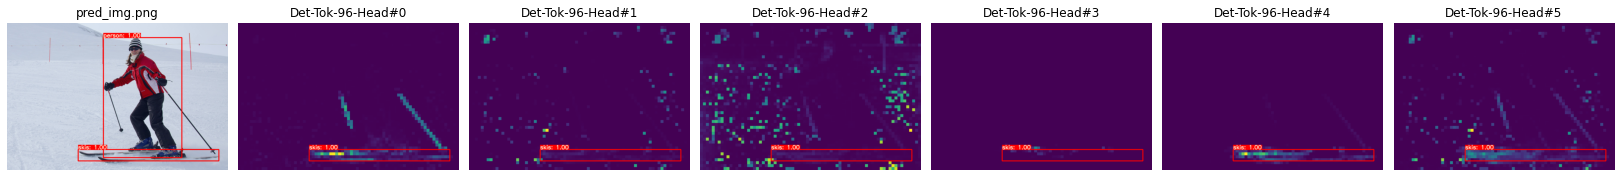

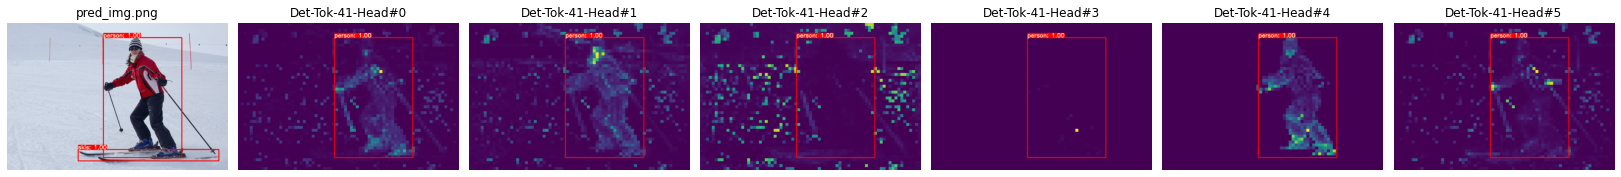

In [9]:
# dettoken_dir_0=det_tok_dirs[0]

# fig, axs = plt.subplots(constrained_layout=True, ncols=7, nrows=len(det_tok_dirs), figsize=(22, 7))
for dettoken_dir in det_tok_dirs:
    fig = plt.figure(constrained_layout=True, figsize=(32 * 0.7, 5 * 0.7), facecolor='white')
    gs = fig.add_gridspec(1, 7)
    axs_0 = [
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[0, 2]),
        fig.add_subplot(gs[0, 3]),
        fig.add_subplot(gs[0, 4]),
        fig.add_subplot(gs[0, 5]),
        fig.add_subplot(gs[0, 6]),
    ]
    dettoken_heads = ['attn-head0.png', 'attn-head1.png', 'attn-head2.png',
                      'attn-head3.png', 'attn-head4.png', 'attn-head5.png']
    dettoken_dir_files_0 = []
    for dettoken_head in dettoken_heads:
        dettoken_dir_files_0.append(os.path.join(dettoken_dir, dettoken_head))
    head_index=0
    for dettoken_dir_file, head_ax in zip(dettoken_dir_files_0, axs_0):
        im = Image.open(dettoken_dir_file)
        head_ax.imshow(im)
        head_ax.set_title('%s-Head#%d' %(dettoken_dir.split('/')[-1], head_index))
        head_ax.axis('off')
        head_index = head_index+1
    fleft_ax = fig.add_subplot(gs[0, 0])
    im = Image.open(os.path.join(args.output_dir, 'pred_img.png'))
    fleft_ax.imshow(im)
    fleft_ax.axis('off')
    fleft_ax.set_title('pred_img.png')
    fig.savefig(os.path.join(dettoken_dir, dettoken_dir.split('/')[-1]+'_'+'attn.png'), facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)
#     plt.close(fig)